# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Chapter-11" data-toc-modified-id="Chapter-11-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Chapter 11</a></div><div class="lev2 toc-item"><a href="#Setup-and-imports" data-toc-modified-id="Setup-and-imports-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Setup and imports</a></div><div class="lev2 toc-item"><a href="#Section-11.1" data-toc-modified-id="Section-11.1-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Section 11.1</a></div><div class="lev3 toc-item"><a href="#Program-11.1" data-toc-modified-id="Program-11.1-121"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Program 11.1</a></div>

# Chapter 11

## Setup and imports

In [1]:
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Section 11.1

### Program 11.1

In [2]:
df1 = pd.DataFrame({
    'A': [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    'Y': [
        200, 150, 220, 110, 50, 180, 90, 170,
        170, 30, 70, 110, 80, 50, 10, 20
    ]
})

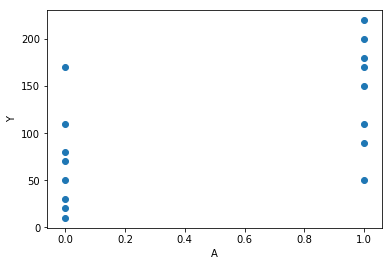

In [3]:
fig, ax = plt.subplots()

ax.scatter(df1['A'], df1['Y'])
ax.set_xlabel('A')
ax.set_ylabel('Y');

In [4]:
df1.groupby('A').mean()

,Y
A,
0,67.50
1,146.25


"Now suppose treatment A is a polytomous variable that can take 4 possible values"

In [5]:
df2 = pd.DataFrame({
    'A': [
        1, 1, 1, 1, 2, 2, 2, 2,
        3, 3, 3, 3, 4, 4, 4, 4
    ],
    'Y': [
        110, 80, 50, 40, 170, 30, 70, 50,
        110, 50, 180, 130, 200, 150, 220, 210
    ]
})

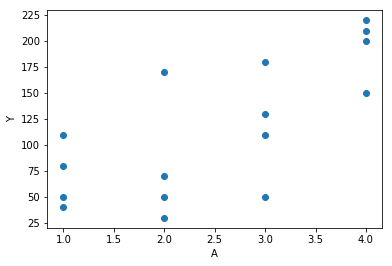

In [6]:
fig, ax = plt.subplots()

ax.scatter(df2['A'], df2['Y'])
ax.set_xlabel('A')
ax.set_ylabel('Y');

In [7]:
df2.groupby('A').mean()

,Y
A,
1,70.0
2,80.0
3,117.5
4,195.0


In [8]:
A, Y = zip(*(
    (3, 21),
    (11, 54),
    (17, 33),
    (23, 101),
    (29, 85),
    (37, 65),
    (41, 157),
    (53, 120),
    (67, 111),
    (79, 200),
    (83, 140),
    (97, 220),
    (60, 230),
    (71, 217),
    (15, 11),
    (45, 190),
))

In [9]:
df3 = pd.DataFrame({'A': A, 'Y': Y, 'constant': np.ones(16)})

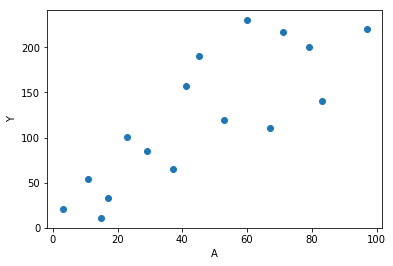

In [10]:
fig, ax = plt.subplots()

ax.scatter(df3.A, df3.Y)
ax.set_xlabel('A')
ax.set_ylabel('Y');

In [96]:
with pm.Model() as df3_linear_model:
    theta_0 = pm.Normal('theta_0', mu=0, sd=40)
    theta_1 = pm.Normal('theta_1', mu=0, sd=40)
    mean = theta_0 + theta_1 * df3['A']
    sigma = pm.Uniform('sigma', 0, 80)
    pm.Normal('observed', mu=mean, sd=sigma, observed=df3['Y'])
    
    df3_linear_traces = pm.sample(draws=2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, theta_1, theta_0]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:04<00:00, 2853.23draws/s]


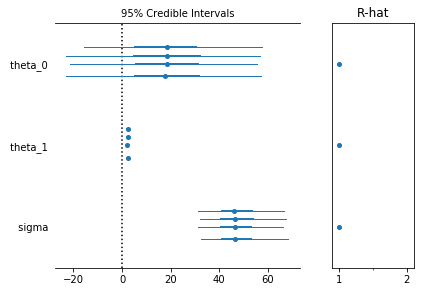

In [97]:
pm.forestplot(df3_linear_traces)

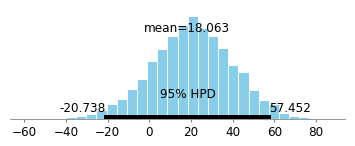

In [98]:
pm.plot_posterior(df3_linear_traces['theta_0'])

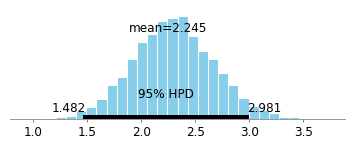

In [99]:
pm.plot_posterior(df3_linear_traces['theta_1'])

In [100]:
posterior_mean_prediction_df3 = df3_linear_traces['theta_0'] + \
        df3_linear_traces['theta_1'] * 90 

In [110]:
print('point-estimate E[Y|A=90]:', posterior_mean_prediction_df3.mean())

point-estimate E[Y|A=90]: 220.116926066


In [101]:
full_posterior_df3_prediction = np.random.normal(
    loc=posterior_mean_prediction_df3,
    scale=df3_linear_traces['sigma']
)

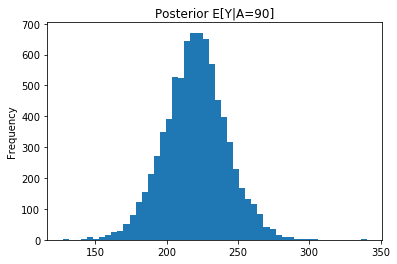

In [102]:
pd.Series(
    posterior_mean_prediction_df3
).plot.hist(bins=50, title='Posterior E[Y|A=90]')

In [103]:
def credible_interval(lower=0.025, upper=0.975, values='Give me an array'):
    sorted_values = np.sort(values)
    length = sorted_values.shape[0]
    return (
        round(sorted_values[int(lower * length)], 2), 
        round(sorted_values[int(upper * length)], 2)
    )


In [104]:
print(
    "95% Credible Interval for E[Y|A=90]:",
    credible_interval(values=posterior_mean_prediction_df3)
)

95% Credible Interval for E[Y|A=90]: (177.09999999999999, 264.00999999999999)


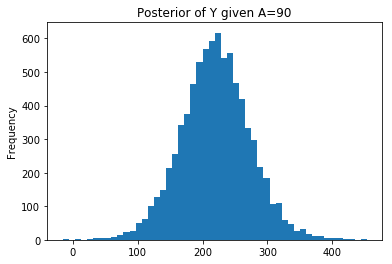

In [105]:
pd.Series(full_posterior_df3_prediction).plot.hist(bins=50, title='Posterior of Y given A=90')

In [113]:
posterior_mean_prediction_df3.shape

(8000,)

In [115]:
num_items_in_x = 1000
shape = (num_items_in_x, posterior_mean_prediction_df3.shape[0])
mean_collection_linear = np.zeros(shape)
posterior_collection_linear = np.zeros(shape)

x_values = np.linspace(
    start=0, 
    stop=100, 
    num=num_items_in_x
)

for i in range(0, num_items_in_x):
    mean_collection_linear[i,:] = df3_linear_traces['theta_0'] + \
        df3_linear_traces['theta_1'] * x_values[i]
    
    posterior_collection_linear[i,:] = np.random.normal(
        loc=mean_collection_linear[i, :],
        scale=df3_linear_traces['sigma']
    )

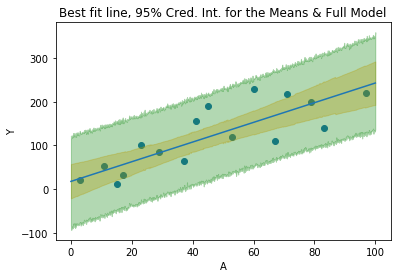

In [117]:
fig, ax = plt.subplots()

ax.scatter(df3.A, df3.Y)
ax.set_xlabel('A')
ax.set_ylabel('Y');

# plot best guess
ax.plot(
    x_values,
    df3_linear_traces['theta_0'].mean() + \
        df3_linear_traces['theta_1'].mean() * x_values
)

# plot 95% Credible Intervals for means, given A=a
ax.fill_between(
    x_values,
    pm.hpd(mean_collection_linear.T).T[0],
    pm.hpd(mean_collection_linear.T).T[1],
    color='orange',
    alpha=0.3
)

# plot 95% Credible Intervals for full posterior, given A=a
ax.fill_between(
    x_values,
    pm.hpd(posterior_collection_linear.T).T[0],
    pm.hpd(posterior_collection_linear.T).T[1],
    color='green',
    alpha=0.3
)

ax.set_title('Best fit line, 95% Cred. Int. for the Means & Full Model')

In [122]:
with pm.Model() as df3_quadratic_model:
    theta_0 = pm.Normal('theta_0', mu=0, sd=40)
    theta_1 = pm.Normal('theta_1', mu=0, sd=40)
    theta_2 = pm.Normal('theta_2', mu=0, sd=40)
    mean = theta_0 + theta_1 * df3['A'] + theta_2 * df3['A'] * df3['A']
    sigma = pm.Uniform('sigma', 0, 80)
    pm.Normal('observed', mu=mean, sd=sigma, observed=df3['Y'])
    
    df3_quadratic_traces = pm.sample(draws=2000, tune=4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, theta_2, theta_1, theta_0]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:25<00:00, 933.80draws/s] 
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c460a8dd8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1c46042208>], dtype=object)

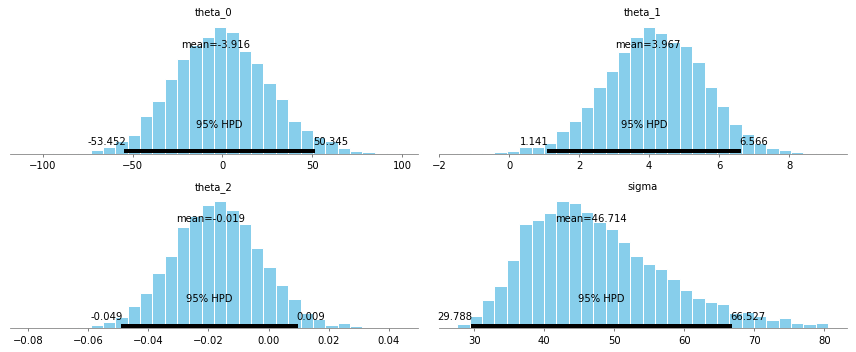

In [126]:
pm.plot_posterior(df3_quadratic_traces)

In [124]:
num_items_in_x = 1000
shape = (num_items_in_x, posterior_mean_prediction_df3.shape[0])
mean_collection_quadratic = np.zeros(shape)
posterior_collection_quadratic = np.zeros(shape)

x_values = np.linspace(
    start=0, 
    stop=100, 
    num=num_items_in_x
)

for i in range(0, num_items_in_x):
    mean_collection_quadratic[i,:] = df3_quadratic_traces['theta_0'] + \
        df3_quadratic_traces['theta_1'] * x_values[i] + \
        df3_quadratic_traces['theta_2'] * x_values[i] * x_values[i]
    
    posterior_collection_quadratic[i,:] = np.random.normal(
        loc=mean_collection_quadratic[i, :],
        scale=df3_quadratic_traces['sigma']
    )

In [129]:
quadratic_mean_estimate = df3_quadratic_traces['theta_0'] + \
        df3_quadratic_traces['theta_1'] * 90 + \
        df3_quadratic_traces['theta_2'] * 90 * 90

In [132]:
print('95% Credible Interval E[Y|A=90]:', pm.hpd(quadratic_mean_estimate))

95% Credible Interval E[Y|A=90]: [ 142.59044637  251.29709057]


In [133]:
print('Best Estimate E[Y|A=90]:', quadratic_mean_estimate.mean())

Best Estimate E[Y|A=90]: 197.720310828


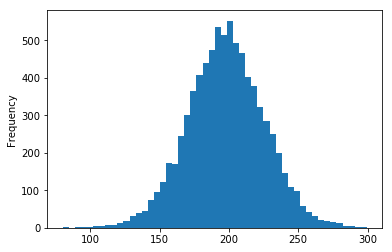

In [130]:
pd.Series(
    quadratic_mean_estimate
).plot.hist(bins=50)

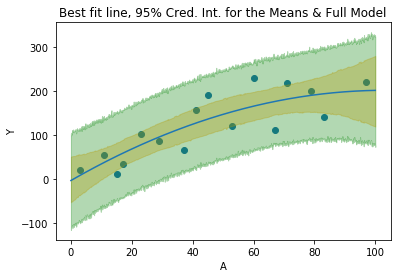

In [125]:
fig, ax = plt.subplots()

ax.scatter(df3.A, df3.Y)
ax.set_xlabel('A')
ax.set_ylabel('Y');

# plot best guess
ax.plot(
    x_values,
    df3_quadratic_traces['theta_0'].mean() + \
        df3_quadratic_traces['theta_1'].mean() * x_values + \
        df3_quadratic_traces['theta_2'].mean() * x_values * x_values
)

# plot 95% Credible Intervals for means, given A=a
ax.fill_between(
    x_values,
    pm.hpd(mean_collection_quadratic.T).T[0],
    pm.hpd(mean_collection_quadratic.T).T[1],
    color='orange',
    alpha=0.3
)

# plot 95% Credible Intervals for full posterior, given A=a
ax.fill_between(
    x_values,
    pm.hpd(posterior_collection_quadratic.T).T[0],
    pm.hpd(posterior_collection_quadratic.T).T[1],
    color='green',
    alpha=0.3
)

ax.set_title('Best fit line, 95% Cred. Int. for the Means & Full Model')